In [1]:
import datetime
import os
import yaml

import numpy as np
import pandas as pd

In [2]:
# Lecture du fichier d'environnement
ENV_FILE = '../env.yaml'
with open(ENV_FILE) as f:
    params = yaml.load(f) #, Loader=yaml.FullLoader)

# Initialisation des chemins vers les fichiers
ROOT_DIR = os.path.dirname(os.path.abspath(ENV_FILE))
DATA_FILE = os.path.join(ROOT_DIR,
                         params['directories']['processed'],
                         params['files']['all_data'])

# Lecture du fichier de données
epidemie_df = (pd.read_csv(DATA_FILE, parse_dates=['Last Update'])
               .assign(day=lambda _df: _df['Last Update'].dt.date)
               .drop_duplicates(subset=['Country/Region', 'Province/State', 'day'])
               [lambda df: df['day'] <= datetime.date(2020, 3, 12)]
              )

C:\Users\Gab\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


In [3]:
epidemie_df.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,source,FIPS,Admin2,Active,Combined_Key,day
0,Anhui,Mainland China,2020-01-22 17:00:00,1.0,NaN,NaN,31.8257,117.2264,01-22-2020.csv,NaN,NaN,NaN,NaN,2020-01-22
1,Beijing,Mainland China,2020-01-22 17:00:00,14.0,NaN,NaN,40.1824,116.4142,01-22-2020.csv,NaN,NaN,NaN,NaN,2020-01-22
2,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,NaN,NaN,30.0572,107.8740,01-22-2020.csv,NaN,NaN,NaN,NaN,2020-01-22
3,Fujian,Mainland China,2020-01-22 17:00:00,1.0,NaN,NaN,26.0789,117.9874,01-22-2020.csv,NaN,NaN,NaN,NaN,2020-01-22
4,Gansu,Mainland China,2020-01-22 17:00:00,NaN,NaN,NaN,36.0611,103.8343,01-22-2020.csv,NaN,NaN,NaN,NaN,2020-01-22


In [4]:
france_df = (epidemie_df[epidemie_df['Country/Region'] == 'France']
             .groupby(['Country/Region', 'day'])
             .agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})
             .reset_index()
            )
france_df.tail()

,Country/Region,day,Confirmed,Deaths,Recovered
23,France,2020-03-07,949.0,11.0,12.0
24,France,2020-03-08,1126.0,19.0,12.0
25,France,2020-03-09,1209.0,19.0,12.0
26,France,2020-03-10,1784.0,33.0,12.0
27,France,2020-03-11,2287.0,48.0,12.0


In [5]:
france_df['Confirmed'].diff()

0       NaN
1       1.0
2       0.0
3       0.0
4       1.0
5       1.0
6       0.0
7       0.0
8       1.0
9       5.0
10      0.0
11      1.0
12      2.0
13      4.0
14     20.0
15     19.0
16     43.0
17     30.0
18     61.0
19     13.0
20     81.0
21     92.0
22    276.0
23    296.0
24    177.0
25     83.0
26    575.0
27    503.0
Name: Confirmed, dtype: float64

In [6]:
def get_country(self, country):
    return (epidemie_df[epidemie_df['Country/Region'] == country]
            .groupby(['Country/Region', 'day'])
            .agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})
            .reset_index()
           )

# Monkey Patch pd.DataFrame
pd.DataFrame.get_country = get_country

In [7]:
get_country(epidemie_df, "South Korea").head()

,Country/Region,day,Confirmed,Deaths,Recovered
0,South Korea,2020-01-22,1.0,0.0,0.0
1,South Korea,2020-01-23,1.0,0.0,0.0
2,South Korea,2020-01-24,2.0,0.0,0.0
3,South Korea,2020-01-25,2.0,0.0,0.0
4,South Korea,2020-01-26,3.0,0.0,0.0


In [8]:
epidemie_df.get_country("South Korea").head()

,Country/Region,day,Confirmed,Deaths,Recovered
0,South Korea,2020-01-22,1.0,0.0,0.0
1,South Korea,2020-01-23,1.0,0.0,0.0
2,South Korea,2020-01-24,2.0,0.0,0.0
3,South Korea,2020-01-25,2.0,0.0,0.0
4,South Korea,2020-01-26,3.0,0.0,0.0


In [9]:
italy_df = epidemie_df.get_country('Italy')
italy_df.head()

,Country/Region,day,Confirmed,Deaths,Recovered
0,Italy,2020-01-31,2.0,0.0,0.0
1,Italy,2020-02-07,3.0,0.0,0.0
2,Italy,2020-02-21,20.0,1.0,0.0
3,Italy,2020-02-22,62.0,2.0,1.0
4,Italy,2020-02-23,155.0,3.0,2.0


In [10]:
korea_df = (epidemie_df[epidemie_df['Country/Region'] == 'South Korea']
             .groupby(['Country/Region', 'day'])
             .agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})
             .reset_index()
            )
korea_df.tail()

,Country/Region,day,Confirmed,Deaths,Recovered
38,South Korea,2020-03-05,6088.0,35.0,41.0
39,South Korea,2020-03-06,6593.0,42.0,135.0
40,South Korea,2020-03-07,7041.0,44.0,135.0
41,South Korea,2020-03-08,7314.0,50.0,118.0
42,South Korea,2020-03-09,7478.0,53.0,118.0


In [11]:
korea_df['infected'] = korea_df['Confirmed'].diff()
italy_df['infected'] = italy_df['Confirmed'].diff()

C:\Users\Gab\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


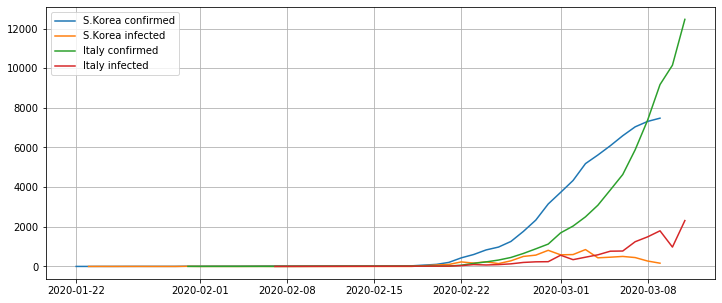

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 5))
plt.plot(korea_df['day'], korea_df['Confirmed'], label='S.Korea confirmed')
plt.plot(korea_df['day'], korea_df['infected'], label='S.Korea infected')
plt.plot(italy_df['day'], italy_df['Confirmed'], label='Italy confirmed')
plt.plot(italy_df['day'], italy_df['infected'], label='Italy infected')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
beta, gamma = [0.01, 0.1]

def SIR(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

In [25]:
korea_df.loc[2:].head()

,Country/Region,day,Confirmed,Deaths,Recovered,infected
2,South Korea,2020-01-24,2.0,0.0,0.0,1.0
3,South Korea,2020-01-25,2.0,0.0,0.0,0.0
4,South Korea,2020-01-26,3.0,0.0,0.0,1.0
5,South Korea,2020-01-27,4.0,0.0,0.0,1.0
6,South Korea,2020-01-28,4.0,0.0,0.0,0.0


In [26]:
from scipy.integrate import solve_ivp

beta, gamma = [0.01, 0.1]
solution_korea = solve_ivp(SIR, [0, 40], [51_470_000, 1, 0], t_eval=np.arange(0, 40, 1))

In [27]:
solution_korea

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 11406320
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])
 t_events: None
        y: array([[ 5.14700000e+07,  8.12315949e-07,  1.58795501e-06,
        -6.11496054e-07,  1.36615061e-06, -3.22556764e-07,
        -1.93104221e-07,  7.71965291e-07, -1.68864907e-07,
         1.06585412e-06, -6.11197660e-07,  1.44060939e-06,
        -1.12329009e-06,  7.22805066e-07, -1.17917756e-06,
         7.52961001e-07,  1.37573581e-06,  4.88191093e-07,
        -3.28007828e-07,  5.31566053e-07, -7.40348178e-08,
         4.93680791e-07,  6.02739684e-07, -2.47002082e-07,
         8.31007760e-07, -3.08101699e-07, -5.18619282e-07,
         3.68423388e-07,  3.03307357e-07, -5.40378765e-07,
        -1.168838

In [17]:
def plot_epidemia(solution, infected, susceptible=False):
    fig = plt.figure(figsize=(12, 5))
    if susceptible:
        plt.plot(solution.t, solution.y[0])
    plt.plot(solution.t, solution.y[1])
    plt.plot(solution.t, solution.y[2])
    plt.plot(infected.reset_index(drop=True).index, infected, "k*:")
    plt.grid("True")
    if susceptible:
        plt.legend(["Susceptible", "Infected", "Recovered", "Original Data"])
    else:
        plt.legend(["Infected", "Recovered", "Original Data"])
    plt.show()

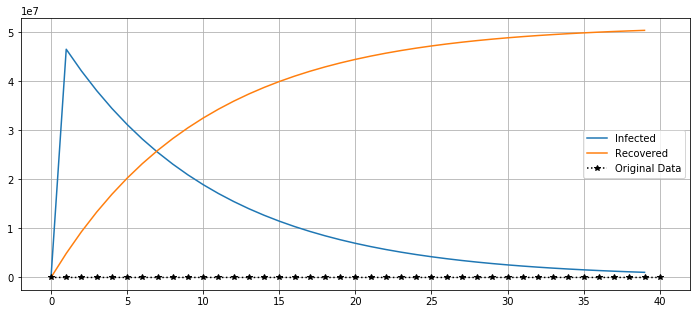

In [18]:
plot_epidemia(solution_korea, korea_df.loc[2:]['infected'])

### Approximation

In [19]:
korea_df['infected'].max() 

851.0

In [20]:
korea_df['infected'].diff().max()

252.0

In [21]:
(korea_df['Recovered'].diff().loc[korea_df['infected'] != 0] / korea_df.loc[korea_df['infected'] != 0]['infected']).mean()

0.17870945831971552

In [28]:
beta, gamma = [0.001, 0.1]
solution_korea = solve_ivp(SIR, [0, 40], [51_470_000, 1, 0], t_eval=np.arange(0, 41, 1))

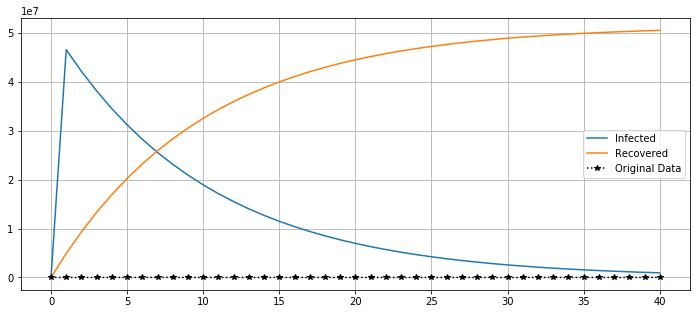

In [29]:
plot_epidemia(solution_korea, korea_df.loc[2:]['infected'])

In [30]:
def sumsq_error(parameters):
    beta, gamma = parameters
    
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

    solution = solve_ivp(SIR, [0, nb_steps-1], [total_population, 1, 0], t_eval=np.arange(0, nb_steps, 1))
    
    return(sum((solution.y[1]-infected_population)**2))

In [31]:
total_population = 51_470_000
infected_population = korea_df.loc[2:]['infected']
nb_steps = len(infected_population)

In [32]:
%%time
from scipy.optimize import minimize

msol = minimize(sumsq_error, [0.001, 0.1], method='Nelder-Mead')
msol.x

Wall time: 16min 53s


array([ 0.1499158 , 81.01959328])

In [33]:
# Djiby
beta_optimal = 5.67e-3
gamma_optimal = 24.7

# PC de la fac
beta_optimal = 0.06321101
gamma_optimal = 33.06340503

# Approximation Excel
beta_optimal = 1.5485e-9
gamma_optimal = 0.1839

In [34]:
beta = beta_optimal
gamma = gamma_optimal

def SIR(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

solution_korea_optimal = solve_ivp(SIR, [0, 40], [51_470_000*0.1, 1, 0], t_eval=np.arange(0, 40, 1))

In [35]:
solution_korea_optimal

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 68
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])
 t_events: None
        y: array([[5.14700000e+06, 5.14699999e+06, 5.14699999e+06, 5.14699998e+06,
        5.14699998e+06, 5.14699997e+06, 5.14699997e+06, 5.14699997e+06,
        5.14699997e+06, 5.14699996e+06, 5.14699996e+06, 5.14699996e+06,
        5.14699996e+06, 5.14699996e+06, 5.14699996e+06, 5.14699996e+06,
        5.14699996e+06, 5.14699996e+06, 5.14699996e+06, 5.14699996e+06,
        5.14699996e+06, 5.14699996e+06, 5.14699996e+06, 5.14699996e+06,
        5.14699996e+06, 5.14699996e+06, 5.14699996e+06, 5.14699996e+06,
        5.14699996e+06, 5.14699995e+06, 5.14699995e+06, 5.14699995e+06,
        5.14699995e+06, 5.14699995e+0

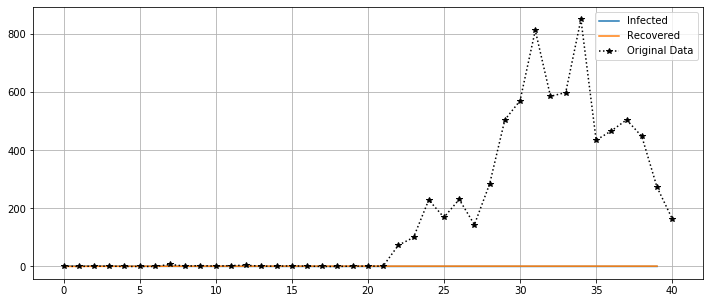

In [36]:
plot_epidemia(solution_korea_optimal, korea_df.loc[2:]['infected'])

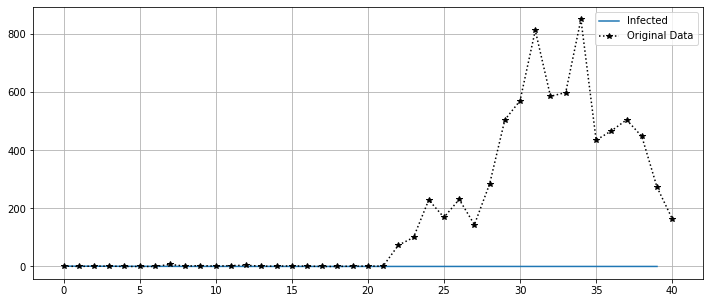

In [37]:
fig = plt.figure(figsize=(12, 5))
plt.plot(solution_korea_optimal.t, solution_korea_optimal.y[1])
plt.plot(korea_df.loc[2:]['infected'].reset_index(drop=True).index, korea_df.loc[2:]['infected'], "k*:")
plt.grid("True")
plt.legend(["Infected", "Original Data"])
plt.show()

In [38]:
china_df = epidemie_df.get_country('Mainland China')[:49]
china_df.tail()

,Country/Region,day,Confirmed,Deaths,Recovered
44,Mainland China,2020-03-06,79771.0,3029.0,53172.0
45,Mainland China,2020-03-07,78619.0,3051.0,53511.0
46,Mainland China,2020-03-08,79455.0,3084.0,56114.0
47,Mainland China,2020-03-09,76902.0,3071.0,55004.0
48,Mainland China,2020-03-10,77201.0,3088.0,56620.0


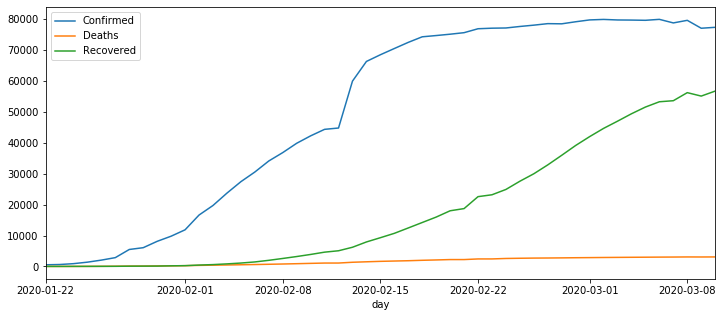

In [39]:
china_df.set_index('day').plot.line(figsize=(12, 5));

In [40]:
beta, gamma = [0.001, 0.1]
china_df['infected'] = china_df['Confirmed'].diff()
nb_steps = china_df.shape[0]
solution_china = solve_ivp(SIR, [0, nb_steps-1], [1_350_000_000, 1, 0], t_eval=np.arange(0, nb_steps, 1))

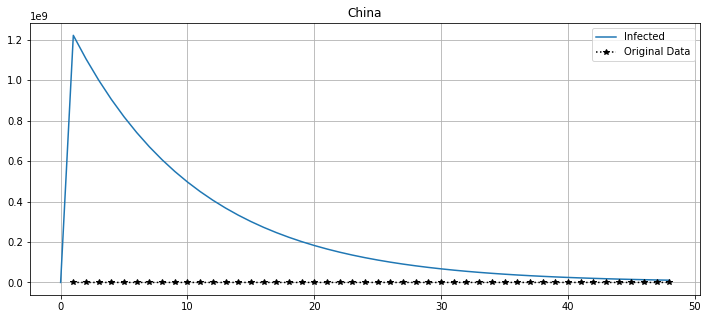

In [41]:
fig = plt.figure(figsize=(12, 5))
plt.plot(solution_china.t, solution_china.y[1])
plt.plot(china_df['infected'].reset_index(drop=True).index, china_df['infected'], "k*:")
plt.title('China')
plt.grid("True")
plt.legend(["Infected", "Original Data"])
plt.show()

In [42]:
korea_df.to_clipboard()